Autor: Natalia Betancur Herrera

Fecha: 22/09/2025

# Laboratorio 4 Codificación y transformación de variables

En esta sesión daremos un paso clave en el camino hacia la inteligencia artificial, preparar los datos para que los modelos puedan entenderlos y aprender de ellos. Esto implica transformar variables categóricas y numéricas para que sean compatibles con algoritmos de aprendizaje automático.


En este laboratorio aprenderás a:
* Identificación de variables categóricas y numéricas
* Codificación de variables categóricas
* Transformación de variables numéricas


In [1]:
# Instalación de PySpark
!pip install pyspark

# Importar librerías principales
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from datetime import datetime
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer, StringIndexer, OneHotEncoder, VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Crear la sesión de Spark
spark = SparkSession.builder \
    .appName("Laboratorio_4_Codificacion_y_Transformaciones") \
    .getOrCreate()

print(" Sesión de Spark iniciada correctamente")

 Sesión de Spark iniciada correctamente


# Cargar el dataset


In [2]:
# Clonar el repositorio
!git clone https://github.com/NataliaBetancurH/pyspark-tutorial.git


# Cargar los datos
df = spark.read.csv("/content/pyspark-tutorial/dataset_salariales.csv", header=True, inferSchema=True)


# Verificar tipo y estructura
print(f"Tipo de objeto df: {type(df)}")
df.show(5)

Cloning into 'pyspark-tutorial'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 35 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 53.74 KiB | 3.84 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Tipo de objeto df: <class 'pyspark.sql.dataframe.DataFrame'>
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              SE|             FT|Principal Data Sc...| 80000|            EUR|        85847|

In [3]:
df.printSchema()

root
 |-- work_year: integer (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- salary_currency: string (nullable = true)
 |-- salary_in_usd: integer (nullable = true)
 |-- employee_residence: string (nullable = true)
 |-- remote_ratio: integer (nullable = true)
 |-- company_location: string (nullable = true)
 |-- company_size: string (nullable = true)



El conjunto de datos Data Science Job Salaries contiene 11 columnas, cada una representa:

- `work_year`: El año en que se pagó el salario.
- `experience_level`: El nivel de experiencia en el trabajo durante ese año.
- `employment_type`: El tipo de contrato o modalidad de empleo para el rol.
- `job_title`: El cargo desempeñado durante el año.
- `salary`: El monto total bruto del salario pagado.
- `salary_currency`: La moneda en la que se pagó el salario.
- `salaryinusd`: El salario convertido a dólares estadounidenses (USD).
- `employee_residence`: El país de residencia principal del empleado durante el año laboral.
- `remote_ratio`: El porcentaje del trabajo realizado de forma remota.
- `company_location`: El país de la oficina principal o sucursal contratante del empleador.
- `company_size`: El número promedio de empleados que trabajaron en la empresa durante ese año.


# Análisis exploratorio de los datos


In [4]:
# Filas y columnas
print("Filas:", df.count(), "| Columnas:", len(df.columns))
df.printSchema()

# Conteo de nulos por columna
nulls = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
nulls.show()

Filas: 3755 | Columnas: 11
root
 |-- work_year: integer (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- salary_currency: string (nullable = true)
 |-- salary_in_usd: integer (nullable = true)
 |-- employee_residence: string (nullable = true)
 |-- remote_ratio: integer (nullable = true)
 |-- company_location: string (nullable = true)
 |-- company_size: string (nullable = true)

+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+
|       

In [5]:
# Generar un análisis estadístico
df.describe().show()

+-------+------------------+----------------+---------------+--------------------+------------------+---------------+------------------+------------------+------------------+----------------+------------+
|summary|         work_year|experience_level|employment_type|           job_title|            salary|salary_currency|     salary_in_usd|employee_residence|      remote_ratio|company_location|company_size|
+-------+------------------+----------------+---------------+--------------------+------------------+---------------+------------------+------------------+------------------+----------------+------------+
|  count|              3755|            3755|           3755|                3755|              3755|           3755|              3755|              3755|              3755|            3755|        3755|
|   mean|2022.3736351531293|            NULL|           NULL|                NULL|190695.57177097205|           NULL|137570.38988015978|              NULL|46.271637816245004|      

In [6]:
# Borrar valores faltantes
df = df.dropna()

In [7]:
# Conteo por company_size
df.groupBy("company_size").count().orderBy(F.desc("count")).show(truncate=False)

# Conteo por employment_type
df.groupBy("employment_type").count().orderBy("employment_type").show()


+------------+-----+
|company_size|count|
+------------+-----+
|M           |3153 |
|L           |454  |
|S           |148  |
+------------+-----+

+---------------+-----+
|employment_type|count|
+---------------+-----+
|             CT|   10|
|             FL|   10|
|             FT| 3718|
|             PT|   17|
+---------------+-----+



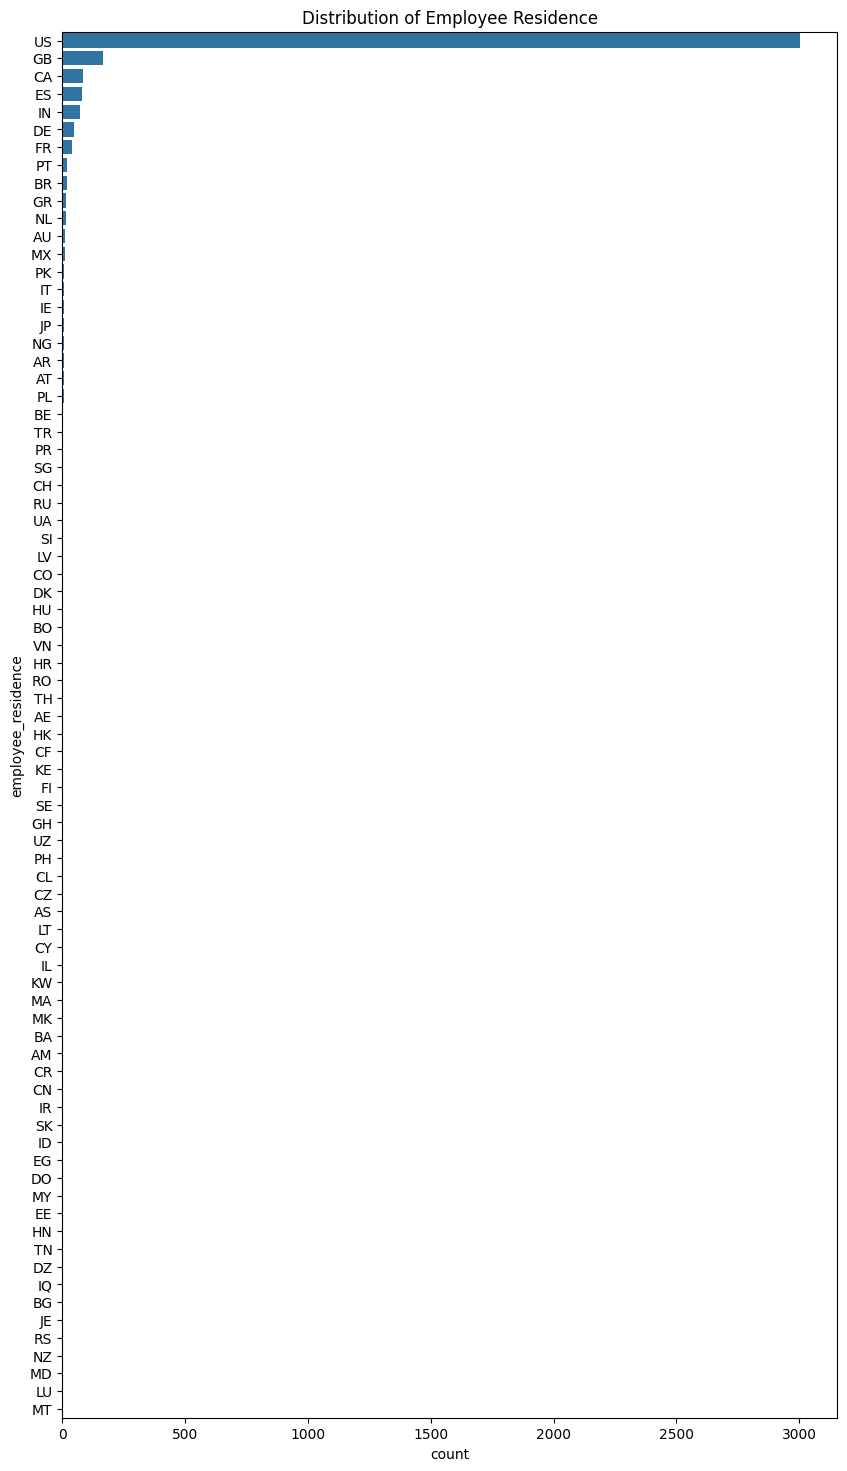

In [8]:
# Visualizar distribuciones
df_pandas = df.toPandas()
plt.figure(figsize=(10,18))
sns.countplot(y='employee_residence', data=df_pandas, order=df_pandas['employee_residence'].value_counts().index)
plt.title('Distribution of Employee Residence')
plt.show()

In [9]:
# filtrado de los datos
df = df.filter(df.employee_residence == 'US')

df.printSchema()

root
 |-- work_year: integer (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- salary_currency: string (nullable = true)
 |-- salary_in_usd: integer (nullable = true)
 |-- employee_residence: string (nullable = true)
 |-- remote_ratio: integer (nullable = true)
 |-- company_location: string (nullable = true)
 |-- company_size: string (nullable = true)



Al filtrar los datos para EE. UU., es necesario eliminar algunas columnas redundantes. Eliminemos `employee_residence`, `salary_currency` (ya que todo está en USD) y `salary` (el salario será el mismo que salary_in_usd después del filtrado)

In [10]:
# borrar columnas redundantes
df = df.drop('employee_residence')
df = df.drop('salary_currency')
df = df.drop('salary')

In [11]:
# Conteo antes de remover duplicados
count_before = df.count()
print(f"Conteo antes de remover duplicados: {count_before}")

# Remover duplicados
df = df.dropDuplicates()

# Conteo después de remover duplicados
count_after = df.count()
print(f"Conteo después de remover duplicados: {count_after}")

# Mostrar duplicados
print(f"Duplicados: {count_before - count_after}")

Conteo antes de remover duplicados: 3004
Conteo después de remover duplicados: 1893
Duplicados: 1111


In [12]:
min_salary = df.agg(F.min(df.salary_in_usd)).first()[0]
max_salary = df.agg(F.max(df.salary_in_usd)).first()[0]

print(f"Salario mínimo: {min_salary}")
print(f"Salario máximo: {max_salary}")

Salario mínimo: 24000
Salario máximo: 450000


Creación de clases basado en el rango salarial:

* Desde 24,000 y hasta 95,375 → Clase 1
* Desde 95,375 y hasta 182,100 → Clase 2
* Desde 182,100 y hasta 231,250 → Clase 3
* Desde 231,250 → Clase 4



In [13]:
# Definir los tramos salariales y etiquetas
brackets = [(95375, 1), (182100, 2), (231250, 3)]

# Construir la expresión condicional encadenada
income_expr = F.when(F.col("salary_in_usd") > 231250, 4)
for limit, label in brackets:
    income_expr = income_expr.when(F.col("salary_in_usd") <= limit, label)

# Aplicar la nueva columna
df = df.withColumn("income_bracket", income_expr)

In [14]:
df = df.drop('salary_in_usd')

In [15]:
# Agrupar por 'income_bracket' y contar los registros
class_counts = (
    df.groupBy("income_bracket")
      .count()
      .orderBy("income_bracket")
      .toPandas()
)

# Mostrar los valores numéricos
print("Conteo por categoría de income_bracket:\n")
print(class_counts.to_string(index=False))


Conteo por categoría de income_bracket:

 income_bracket  count
              1    277
              2   1078
              3    359
              4    179


# Codificación de variables Categoricas


In [16]:
# Indexación de cadenas para columnas categóricas
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in df.columns if str(df.schema[column].dataType) == 'StringType()']

# Codificación para columnas categóricas
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol= column+"_ohe") for column in df.columns if str(df.schema[column].dataType) == 'StringType()']

# Etapas del proceso
stages = indexers + encoders



pipeline = Pipeline(stages=stages)

# Transformación de datos
df = pipeline.fit(df).transform(df)
df.printSchema()

root
 |-- work_year: integer (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- remote_ratio: integer (nullable = true)
 |-- company_location: string (nullable = true)
 |-- company_size: string (nullable = true)
 |-- income_bracket: integer (nullable = true)
 |-- experience_level_index: double (nullable = false)
 |-- employment_type_index: double (nullable = false)
 |-- job_title_index: double (nullable = false)
 |-- company_location_index: double (nullable = false)
 |-- company_size_index: double (nullable = false)
 |-- experience_level_ohe: vector (nullable = true)
 |-- employment_type_ohe: vector (nullable = true)
 |-- job_title_ohe: vector (nullable = true)
 |-- company_location_ohe: vector (nullable = true)
 |-- company_size_ohe: vector (nullable = true)



In [17]:
# Borrar columnas originales
for column in df.columns:
    if str(df.schema[column].dataType) == 'StringType()':
        df = df.drop(column)

df.printSchema()

root
 |-- work_year: integer (nullable = true)
 |-- remote_ratio: integer (nullable = true)
 |-- income_bracket: integer (nullable = true)
 |-- experience_level_index: double (nullable = false)
 |-- employment_type_index: double (nullable = false)
 |-- job_title_index: double (nullable = false)
 |-- company_location_index: double (nullable = false)
 |-- company_size_index: double (nullable = false)
 |-- experience_level_ohe: vector (nullable = true)
 |-- employment_type_ohe: vector (nullable = true)
 |-- job_title_ohe: vector (nullable = true)
 |-- company_location_ohe: vector (nullable = true)
 |-- company_size_ohe: vector (nullable = true)



In [18]:
df.show()

+---------+------------+--------------+----------------------+---------------------+---------------+----------------------+------------------+--------------------+-------------------+---------------+--------------------+----------------+
|work_year|remote_ratio|income_bracket|experience_level_index|employment_type_index|job_title_index|company_location_index|company_size_index|experience_level_ohe|employment_type_ohe|  job_title_ohe|company_location_ohe|company_size_ohe|
+---------+------------+--------------+----------------------+---------------------+---------------+----------------------+------------------+--------------------+-------------------+---------------+--------------------+----------------+
|     2023|           0|             2|                   0.0|                  0.0|            3.0|                   0.0|               0.0|       (3,[0],[1.0])|      (2,[0],[1.0])| (69,[3],[1.0])|       (5,[0],[1.0])|   (2,[0],[1.0])|
|     2023|           0|             2|         

En PySpark, estructuras como (3, [0], [1.0]) representan vectores dispersos, usados para ahorrar memoria al trabajar con datos de alta dimensión, como los generados por One-Hot Encoding.

- El primer número indica el tamaño del vector.
- La segunda lista señala los índices con valores distintos de cero.
- La tercera lista contiene esos valores.

Este formato guarda solo los valores distintos de cero, lo que lo hace eficiente para variables categóricas con muchos niveles. Una vez codificadas, puedes eliminar las columnas indexadas creadas por StringIndexer, ya que solo sirven como paso intermedio y no aportan al modelo final


In [19]:
# Eliminación de columnas categóricas e índices originales
for column in df.columns:
    if column.endswith('_index'):
        df = df.drop(column)

df.printSchema()

root
 |-- work_year: integer (nullable = true)
 |-- remote_ratio: integer (nullable = true)
 |-- income_bracket: integer (nullable = true)
 |-- experience_level_ohe: vector (nullable = true)
 |-- employment_type_ohe: vector (nullable = true)
 |-- job_title_ohe: vector (nullable = true)
 |-- company_location_ohe: vector (nullable = true)
 |-- company_size_ohe: vector (nullable = true)



In [20]:
df.show()

+---------+------------+--------------+--------------------+-------------------+---------------+--------------------+----------------+
|work_year|remote_ratio|income_bracket|experience_level_ohe|employment_type_ohe|  job_title_ohe|company_location_ohe|company_size_ohe|
+---------+------------+--------------+--------------------+-------------------+---------------+--------------------+----------------+
|     2023|           0|             2|       (3,[0],[1.0])|      (2,[0],[1.0])| (69,[3],[1.0])|       (5,[0],[1.0])|   (2,[0],[1.0])|
|     2023|           0|             2|       (3,[0],[1.0])|      (2,[0],[1.0])| (69,[2],[1.0])|       (5,[0],[1.0])|   (2,[0],[1.0])|
|     2023|           0|             2|       (3,[0],[1.0])|      (2,[0],[1.0])| (69,[0],[1.0])|       (5,[0],[1.0])|   (2,[0],[1.0])|
|     2023|         100|             2|       (3,[0],[1.0])|      (2,[0],[1.0])| (69,[0],[1.0])|       (5,[0],[1.0])|   (2,[0],[1.0])|
|     2023|           0|             1|       (3,[1],[1

In [21]:
from pyspark.ml.feature import VectorAssembler

# Definición de las columnas de características
feature_columns = [column for column in df.columns if column != 'income_bracket']

# Separar las características y la etiqueta
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

df = assembler.transform(df)

# Seleccionar características y etiqueta
df = df.select('features', 'income_bracket')

# Transformar los datos
df.printSchema()


root
 |-- features: vector (nullable = true)
 |-- income_bracket: integer (nullable = true)



# Normalizar las características

In [22]:
from pyspark.ml.feature import StandardScaler

# Inicializar standard scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Ajustar el escalador a tus datos
scalerModel = scaler.fit(df)

# Normalizado
df = scalerModel.transform(df)


df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- income_bracket: integer (nullable = true)
 |-- scaled_features: vector (nullable = true)



In [23]:
df.show()

+--------------------+--------------+--------------------+
|            features|income_bracket|     scaled_features|
+--------------------+--------------+--------------------+
|(83,[0,2,5,10,76,...|             2|[0.88167637673653...|
|(83,[0,2,5,9,76,8...|             2|[0.88167637673653...|
|(83,[0,2,5,7,76,8...|             2|[0.88167637673653...|
|(83,[0,1,2,5,7,76...|             2|[0.88167637673653...|
|(83,[0,3,5,7,76,8...|             1|[0.88167637673653...|
|(83,[0,1,2,5,7,76...|             2|[-0.6622767973297...|
|(83,[0,2,5,9,76,8...|             2|[-0.6622767973297...|
|(83,[0,1,3,5,7,76...|             2|[-2.2062299713960...|
|(83,[0,4,5,14,76,...|             2|[0.88167637673653...|
|(83,[0,2,5,7,76,8...|             3|[0.88167637673653...|
|(83,[0,1,2,5,8,76...|             2|[-0.6622767973297...|
|(83,[0,1,4,5,9,76...|             1|[-2.2062299713960...|
|(83,[0,1,2,5,9,76...|             1|[0.88167637673653...|
|(83,[0,2,5,14,76,...|             4|[0.88167637673653..

# Modelado de datos

In [24]:
# Separar en train y test
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [25]:

# Definir los modelos
models = {
    "Decision Tree Classifier": DecisionTreeClassifier(featuresCol='features', labelCol='income_bracket'),
    "Random Forest Classifier": RandomForestClassifier(featuresCol='features', labelCol='income_bracket'),
    "Naive Bayes": NaiveBayes(featuresCol='features', labelCol='income_bracket')
}

# Definir evaluadores
evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='income_bracket', metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='income_bracket', metricName="f1")

# Recorrer los modelos
for model_name, model in models.items():
    # Ajustar el modelo
    model_fit = model.fit(train_data)

    # Predicción
    test_results = model_fit.transform(test_data)
    train_results = model_fit.transform(train_data)

    # Calcular la precisión y la puntuación F1.
    accuracy = evaluator_accuracy.evaluate(test_results)
    f1 = evaluator_f1.evaluate(test_results)
    accuracy_train = evaluator_accuracy.evaluate(train_results)
    f1_train = evaluator_f1.evaluate(train_results)

    # Imprimir los resultados
    print(f"{model_name}: Train Accuracy = {accuracy_train}, Train F1 = {f1_train}")
    print(f"{model_name}: Test Accuracy = {accuracy}, Test F1 = {f1}")


Decision Tree Classifier: Train Accuracy = 0.6019230769230769, Train F1 = 0.5118705330831265
Decision Tree Classifier: Test Accuracy = 0.5675675675675675, Test F1 = 0.48461021731569665
Random Forest Classifier: Train Accuracy = 0.583974358974359, Train F1 = 0.44938958081053976
Random Forest Classifier: Test Accuracy = 0.5855855855855856, Test F1 = 0.44924129678228036
Naive Bayes: Train Accuracy = 0.12692307692307692, Train F1 = 0.10951574760092325
Naive Bayes: Test Accuracy = 0.11711711711711711, Test F1 = 0.10732322111632456
